In [35]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta
from utils_tensorflow import *
from utils import *

mpl.rcParams['figure.figsize'] = (16, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# ticker = 'AAPL'
# HISTORY_START_DATE = '2012-01-01'

# df = si.get_data(ticker)
# df = df[df.index >= HISTORY_START_DATE]
# df['adjclose'].dropna(inplace=True)

In [3]:
ticker = '^GSPC' # ^GSPC is S&P 500 ticker
HISTORY_START_DATE = '2012-01-01'

# df = si.get_data(ticker)
df = load_ticker_data(ticker)
df = df[df.index >= HISTORY_START_DATE]
df['adjclose'].dropna(inplace=True)
df.tail()

,open,high,low,close,adjclose,volume,ticker
2020-06-02,3064.780029,3081.070068,3051.639893,3080.820068,3080.820068,5187230000,^GSPC
2020-06-03,3098.899902,3130.939941,3098.899902,3122.870117,3122.870117,5989560000,^GSPC
2020-06-04,3111.560059,3128.909912,3090.409912,3112.350098,3112.350098,6428130000,^GSPC
2020-06-05,3163.840088,3211.719971,3163.840088,3193.929932,3193.929932,8617590000,^GSPC
2020-06-08,3199.919922,3209.120117,3199.919922,3207.070068,3207.070068,285678364,^GSPC


In [4]:
df.tail()

,open,high,low,close,adjclose,volume,ticker
2020-06-02,3064.780029,3081.070068,3051.639893,3080.820068,3080.820068,5187230000,^GSPC
2020-06-03,3098.899902,3130.939941,3098.899902,3122.870117,3122.870117,5989560000,^GSPC
2020-06-04,3111.560059,3128.909912,3090.409912,3112.350098,3112.350098,6428130000,^GSPC
2020-06-05,3163.840088,3211.719971,3163.840088,3193.929932,3193.929932,8617590000,^GSPC
2020-06-08,3199.919922,3209.120117,3199.919922,3207.070068,3207.070068,285678364,^GSPC


In [5]:
df.shape

(2121, 7)

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F97E6BCB38>],
      dtype=object)

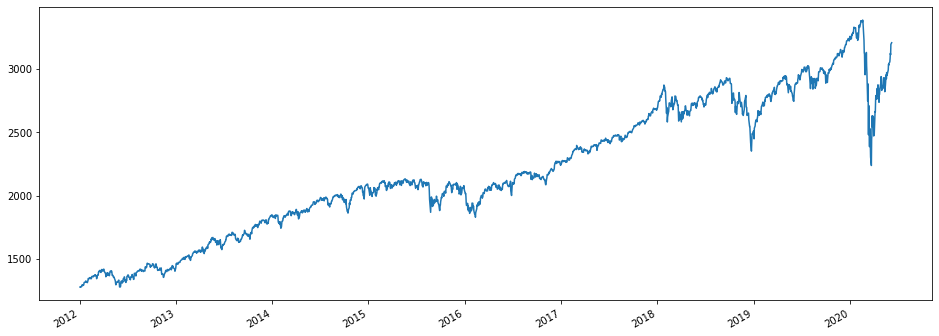

In [6]:
df['adjclose'].plot(subplots=True)

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [7]:
features_considered = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

In [8]:
features = df[df['open'].isna()==False][features_considered]
features = features[features.index > '2012-01-01']
features.head()

,open,high,low,close,adjclose,volume
2012-01-03,1258.859985,1284.619995,1258.859985,1277.060059,1277.060059,3943710000
2012-01-04,1277.030029,1278.729980,1268.099976,1277.300049,1277.300049,3592580000
2012-01-05,1277.300049,1283.050049,1265.260010,1281.060059,1281.060059,4315950000
2012-01-06,1280.930054,1281.839966,1273.339966,1277.810059,1277.810059,3656830000
2012-01-09,1277.829956,1281.989990,1274.550049,1280.699951,1280.699951,3371600000


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F97E6776A0>,
      dtype=object)

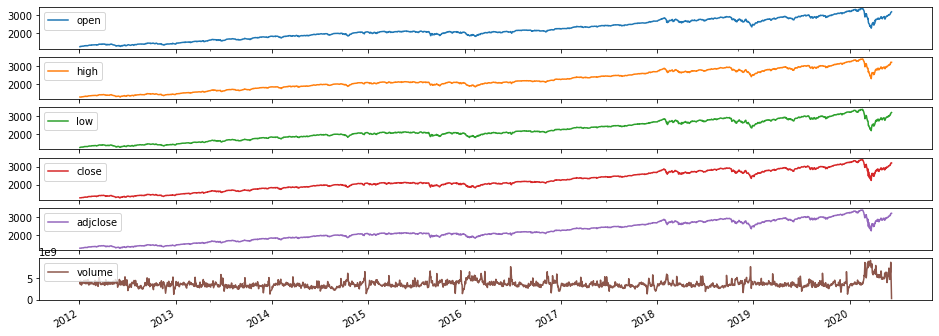

In [9]:
features.plot(subplots=True)

- Standardize data using Min Max Scaler

In [31]:
data_scaled = features.copy()

TRAIN_SPLIT = int(df.shape[0] * 0.75)
print(f"TRAIN_SPLIT: {TRAIN_SPLIT}, TEST SPLIT: {df.shape[0] - TRAIN_SPLIT}")

column_scaler = {}
# scale the data (prices) from 0 to 1
for column in data_scaled.columns:
    
    column_values = data_scaled[column].values.reshape(-1, 1)
    # Fit only on training data
    scaler = MinMaxScaler()
    scaler.fit(column_values[:TRAIN_SPLIT])
    data_scaled[column] = scaler.transform(column_values)
    column_scaler[column] = scaler

data_scaled.tail()

TRAIN_SPLIT: 1590, TEST SPLIT: 531


,open,high,low,close,adjclose,volume
2020-06-02,1.122826,1.130603,1.125680,1.130310,1.130310,0.620348
2020-06-03,1.144040,1.161887,1.155354,1.156660,1.156660,0.746729
2020-06-04,1.151912,1.160613,1.150023,1.150068,1.150068,0.815811
2020-06-05,1.184417,1.212560,1.196130,1.201189,1.201189,1.160690
2020-06-08,1.206849,1.210929,1.218784,1.209423,1.209423,-0.151734


### Multi-Step model

In [64]:
target_variable = 'adjclose'
target_var_index = data_scaled.columns.tolist().index(target_variable)

target = data_scaled[target_variable].values
dataset = data_scaled.values

past_history = 30
future_target = 7
BATCH_SIZE = 64
BUFFER_SIZE = 1000

TEST_SPLIT = dataset.shape[0] - 1 - past_history

train_data = prepare_batches(dataset, target,
                             0, TRAIN_SPLIT,
                             past_history, future_target)
val_data = prepare_batches(dataset, target,
                           TRAIN_SPLIT, TEST_SPLIT,
                           past_history, future_target)

test_data = prepare_test_batch(dataset, TEST_SPLIT, None,  past_history)

In [66]:
[(i[0].numpy(), i[1].numpy()) for i in train_data.take(-1)]

TypeError: take() missing 1 required positional argument: 'count'

- Prepare dates (index for plots)

In [33]:
dates = data_scaled[data_scaled.index > HISTORY_START_DATE].index
dates = np.array(dates.date, 'str')

train_dates = prepare_dates(dates, 0, TRAIN_SPLIT, 
                            past_history, future_target)

val_dates = prepare_dates(dates, TRAIN_SPLIT, TEST_SPLIT, 
                          past_history, future_target)

test_dates = prepare_dates(dates, TEST_SPLIT, None, 
                           past_history, future_target)
test_dates

<RepeatDataset shapes: ((None, 30, 1), (None, 7)), types: (tf.string, tf.string)>

History date range: 2012-01-04 00:00:00, 2012-02-15 00:00:00
Future date range: 2012-02-15 00:00:00, 2012-02-24 00:00:00


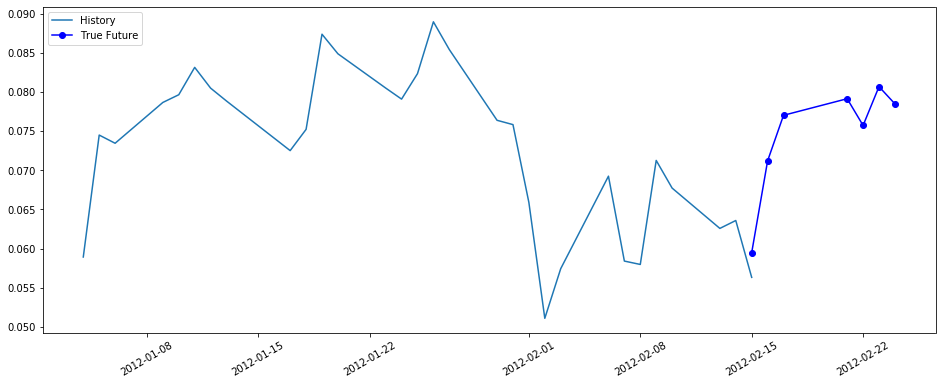

In [13]:
for xy, date in zip(train_data.take(1), train_dates.take(1)):
    
    x, y = xy
#     print(x[0].numpy())
    x_dates, y_dates = date
    history = np.array(x[0])[:, target_var_index]
    true_future = np.array(y[0])
#     print(history)
    
    multi_step_plot_dates(x_dates[0].numpy(), history, y_dates[0].numpy(), true_future)

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [15]:
input_shape = (past_history, len(features_considered))

In [16]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=input_shape))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

# multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model.compile(optimizer='adam', loss='mae')
multi_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 32)            4992      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 7)                 119       
Total params: 8,247
Trainable params: 8,247
Non-trainable params: 0
_________________________________________________________________


Let's see how the model predicts before it trains.

In [17]:
for x, y in val_data.take(1):
    print(multi_step_model.predict(x).shape)

(64, 7)


In [18]:
early_stopping = EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)

multi_step_history = multi_step_model.fit(train_data, epochs=20,
                                          steps_per_epoch=200,
                                          validation_data=val_data,
                                          validation_steps=50,
                                          callbacks=[early_stopping])

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 8s 41ms/step - loss: 0.0531 - val_loss: 0.0556
Epoch 2/20
200/200 [==============================] - 4s 20ms/step - loss: 0.0198 - val_loss: 0.0525
Epoch 3/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0193 - val_loss: 0.0580
Epoch 4/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0182 - val_loss: 0.0608
Epoch 5/20
200/200 [==============================] - 5s 23ms/step - loss: 0.0179 - val_loss: 0.0449
Epoch 6/20
200/200 [==============================] - 4s 21ms/step - loss: 0.0171 - val_loss: 0.0540
Epoch 7/20
200/200 [==============================] - 4s 20ms/step - loss: 0.0166 - val_loss: 0.0522
Epoch 8/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0167 - val_loss: 0.0440
Epoch 9/20
200/200 [==============================] - 4s 19ms/step - loss: 0.0161 - val_loss: 0.0414
Epoch 10/20
200/200 [===========================

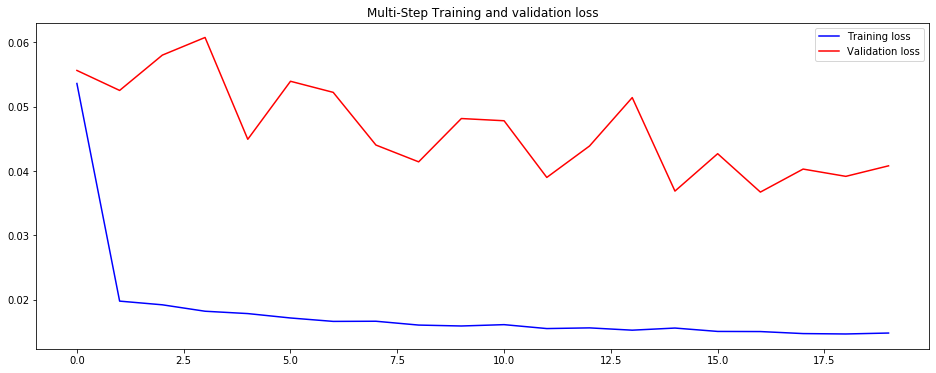

In [19]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

History date range: 2018-05-01 00:00:00, 2018-06-12 00:00:00
Future date range: 2018-06-12 00:00:00, 2018-06-20 00:00:00


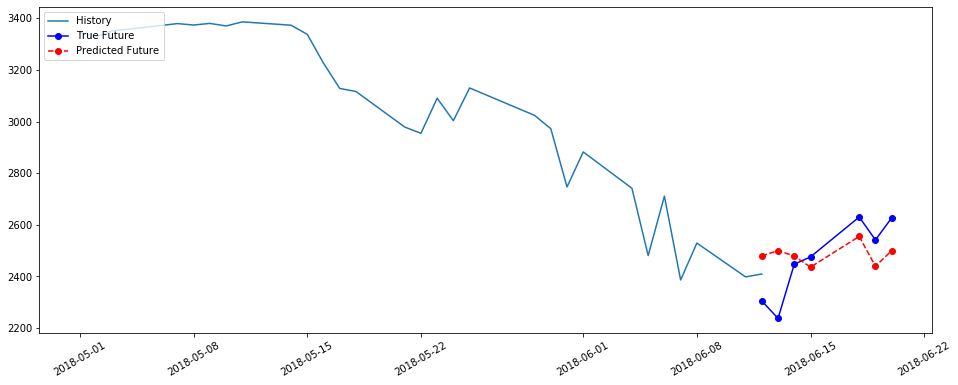

History date range: 2018-08-01 00:00:00, 2018-09-12 00:00:00
Future date range: 2018-09-12 00:00:00, 2018-09-20 00:00:00


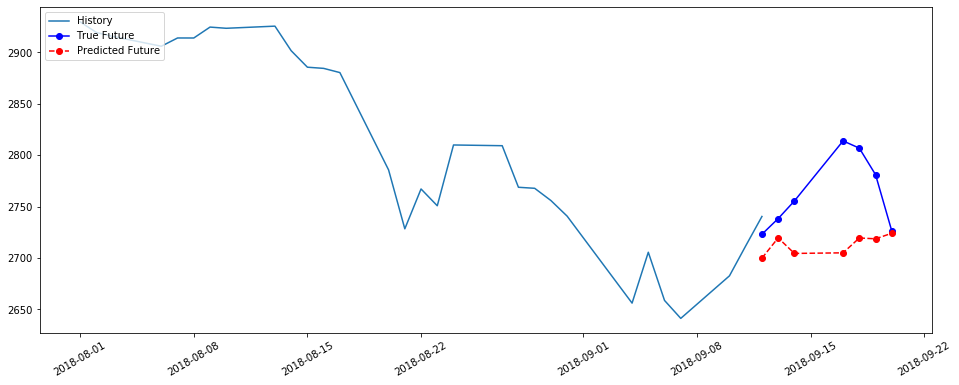

History date range: 2018-10-31 00:00:00, 2018-12-13 00:00:00
Future date range: 2018-12-13 00:00:00, 2018-12-21 00:00:00


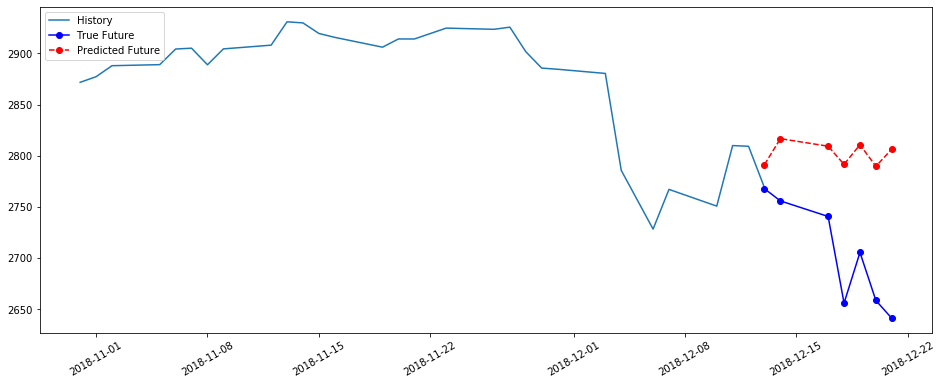

In [20]:
for xy, date in zip(val_data.take(3), val_dates.take(3)):
    
    x, y = xy
    x_dates, y_dates = date
#     print(x[0])
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    true_future = return_original_scale(y[0], column_scaler['adjclose'])
    prediction = multi_step_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), true_future,
                          prediction_rescaled)

In [21]:
df.tail()

,open,high,low,close,adjclose,volume,ticker
2020-06-01,3038.780029,3062.179932,3031.540039,3055.729980,3055.729980,4673410000,^GSPC
2020-06-02,3064.780029,3081.070068,3051.639893,3080.820068,3080.820068,5187230000,^GSPC
2020-06-03,3098.899902,3130.939941,3098.899902,3122.870117,3122.870117,5989560000,^GSPC
2020-06-04,3111.560059,3128.909912,3090.409912,3112.350098,3112.350098,6428130000,^GSPC
2020-06-05,3163.840088,3211.719971,3163.840088,3197.060059,3197.060059,2551558637,^GSPC


History date range: 2020-04-24 00:00:00, 2020-06-05 00:00:00
Future date range: 2020-06-08 00:00:00, 2020-06-16 00:00:00


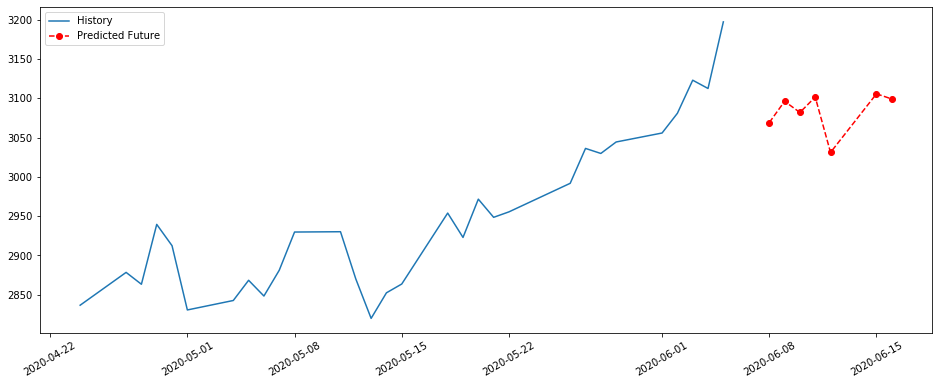

In [22]:
for x, date in zip(test_data.take(1), test_dates.take(1)):
    
    x_dates, y_dates = date
    history = x[0].numpy() [:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
#     print(history)
    prediction = multi_step_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), prediction=prediction_rescaled)

# 2. Bidirectional model

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

import time
import os


def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                 loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False,
                 last_layer_neurons=1, input_shape=(64, 6)):
    model = Sequential()
    
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=input_shape))
            else:
                model.add(cell(units, return_sequences=True, input_shape=input_shape))
                
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
                
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
        
    model.add(Dense(last_layer_neurons, activation="linear"))
    model.compile(loss=loss, optimizer=optimizer,
                  metrics=["mean_absolute_error", "median_absolute_error", "rmse"])
    return model

In [32]:
# construct the model
model = create_model(past_history, loss='mae', units=256, n_layers=2,
                     optimizer="rmsprop", bidirectional=True,
                     last_layer_neurons=future_target)
print(model.summary())
# # some tensorflow callbacks
# tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
early_stopping = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

model_history = model.fit(train_data, epochs=20,
                          steps_per_epoch=200,
                          validation_data=val_data,
                          validation_steps=50,
                          callbacks=[early_stopping],
                          verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 30, 512)           538624    
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 3591      
Total params: 2,117,127
Trainable params: 2,117,127
Non-trainable params: 0
_________________________________________________________________
None
Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 198s 988

[[2781.8518]
 [2767.66  ]
 [2783.7087]
 [2782.8203]
 [2768.0588]
 [2780.4834]
 [2792.2075]]
History date range: 2018-05-01 00:00:00, 2018-06-12 00:00:00
Future date range: 2018-06-12 00:00:00, 2018-06-20 00:00:00


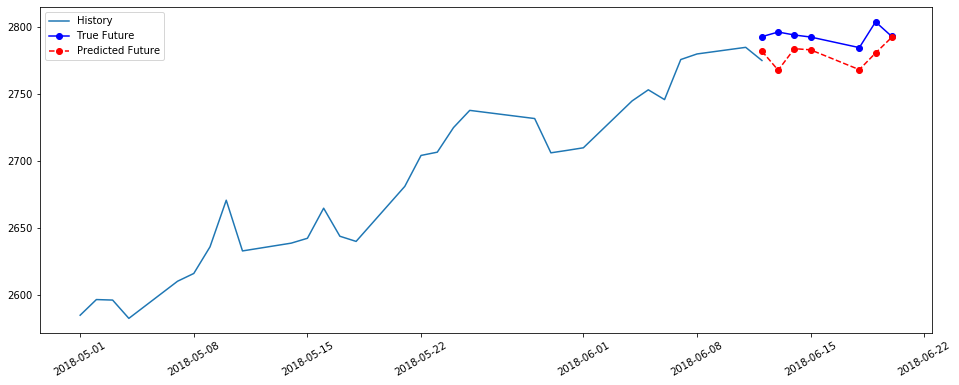

[[3029.1404]
 [3015.806 ]
 [3034.949 ]
 [3033.4912]
 [3016.0728]
 [3030.6543]
 [3045.035 ]]
History date range: 2018-08-01 00:00:00, 2018-09-12 00:00:00
Future date range: 2018-09-12 00:00:00, 2018-09-20 00:00:00


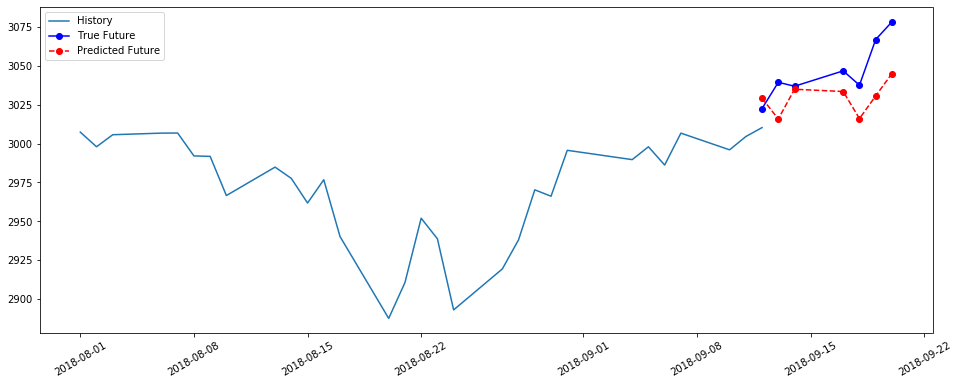

[[2761.4204]
 [2750.5266]
 [2766.7085]
 [2768.4893]
 [2753.293 ]
 [2766.457 ]
 [2777.5686]]
History date range: 2018-10-31 00:00:00, 2018-12-13 00:00:00
Future date range: 2018-12-13 00:00:00, 2018-12-21 00:00:00


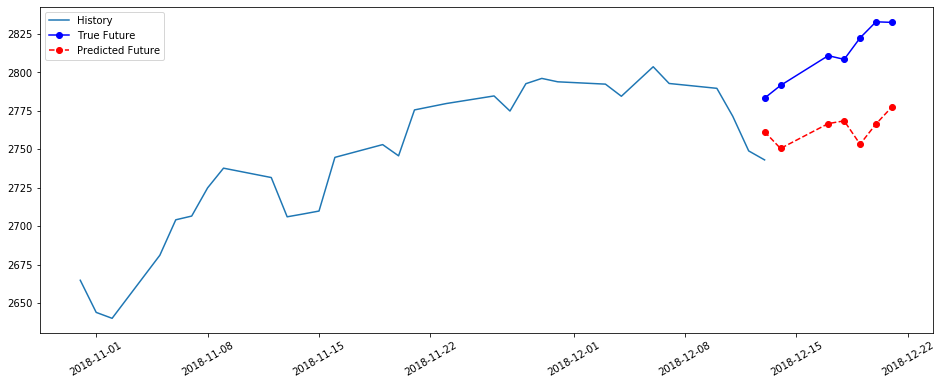

In [33]:
for xy, date in zip(val_data.take(3), val_dates.take(3)):
    
    x, y = xy
    x_dates, y_dates = date
#     print(x[0])
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    true_future = return_original_scale(y[0], column_scaler['adjclose'])
    prediction = model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    print(prediction_rescaled)
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), true_future,
                          prediction_rescaled)

History date range: 2020-04-24 00:00:00, 2020-06-05 00:00:00
Future date range: 2020-06-08 00:00:00, 2020-06-16 00:00:00


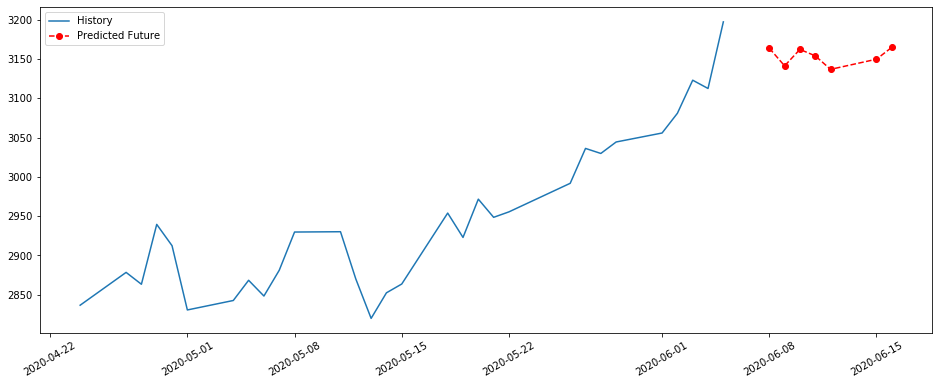

In [34]:
for x, date in zip(test_data.take(1), test_dates.take(1)):
    
    x_dates, y_dates = date
    history = x[0].numpy() [:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
#     print(history)
    prediction = model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), prediction=prediction_rescaled)

# 3. GridSearch for Hyperparameters

In [84]:
def build_model(n_hidden=1, n_neurons=64, learning_rate=3e-3, input_shape=(64, 7),
                dropout=0.3, loss='mean_absolute_error', optimizer='rmsprop',
                bidirectional=False, output_layer_neurons=1, output_layer_activation='linear'):
    
    model = Sequential()
    
    # First layer.
    if bidirectional:
        model.add(Bidirectional(LSTM(n_neurons, return_sequences=True), input_shape=input_shape))
    else:
        model.add(LSTM(n_neurons, return_sequences=True, input_shape=input_shape))    
    
    # Hidden layers.
    for i in range(n_hidden):                
        if i == n_hidden - 1:
            # Last hidden layer.
            if bidirectional:
                model.add(Bidirectional(LSTM(n_neurons, return_sequences=False)))
            else:
                model.add(LSTM(n_neurons, return_sequences=False))    
        else:
            # Hidden layers
            if bidirectional:
                model.add(Bidirectional(LSTM(n_neurons, return_sequences=True)))
            else:
                model.add(LSTM(n_neurons, return_sequences=True))
        # Add dropout after each layer.
        model.add(Dropout(dropout))
        
    # Output layer.
    model.add(Dense(output_layer_neurons, activation=output_layer_activation))
    
    optimizer = keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss=loss, optimizer=optimizer,
                  metrics=["MeanAbsolutePercentageError", "RootMeanSquaredError"])
    
    return model

In [21]:
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV

testing_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [40]:
param_distribs = {
    'n_hidden': [1, 2, 3, 4]
    ,'n_neurons': [32, 64, 128, 256]
    ,'learning_rate': np.arange(1e-3, 1e-1, 1e-3)
    ,'bidirectional': [True, False]
#     ,'dropout': [0.3, 0.5]
#     ,'optimizer': ['adam', 'rmsprop', 'SGD']
#     ,'output_layer_activation': ['linear', 'relu']
}

In [43]:
import os

def get_run_dir(folder_name='models'):
    import time
    root_dir = os.path.join(os.curdir, folder_name)
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_dir, run_id)

In [49]:
tensorboard_cb = TensorBoard(get_run_dir('logs'))
checkpointer_cb = ModelCheckpoint(get_run_dir('models'), save_best_only=True)
earlystopping_cb = EarlyStopping(patience=10)

In [ ]:
testing_model = build_model(n_hidden=1, bidirectional=True)
testing_model.summary()

In [81]:
testing_model.fit(train_data, epochs=20,
                  steps_per_epoch=200,
                  validation_data=val_data,
                  validation_steps=50,
                  callbacks=[earlystopping_cb, tensorboard_cb, checkpointer_cb],
                  verbose=1)

Train for 200 steps, validate for 50 steps
Epoch 1/20
  1/200 [..............................] - ETA: 12sWARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 


ValueError: Error when checking input: expected bidirectional_input to have shape (64, 7) but got array with shape (30, 6)

In [69]:
rnd_search_cv = RandomizedSearchCV(testing_model, param_distribs, n_iter=5, cv=3, n_jobs=-1, verbose=2)
rnd_search_cv.fit(train_data, epochs=20,
                  steps_per_epoch=200,
                  validation_data=val_data,
                  validation_steps=50,
                  callbacks=[earlystopping_cb, tensorboard_cb, checkpointer_cb],
                  verbose=1)

TypeError: Singleton array array(<RepeatDataset shapes: ((None, 30, 6), (None, 7)), types: (tf.float64, tf.float64)>,
      dtype=object) cannot be considered a valid collection.